# Analyzing a lammps trajectory

In this example, a lammps trajectory in dump-text format will be read in, and Steinhardt's parameters will be calculated.

In [1]:
import pyscal as pc
import os
import pyscal.traj_process as ptp
import matplotlib.pyplot as plt
import numpy as np

First, we will use the `split_trajectory` method from `pyscal.traj_process` module to help split the trajectory into individual snapshots.

In [2]:
trajfile = "traj.light"
files = ptp.split_trajectory(trajfile)

`files` contain the individual time slices from the trajectory.

In [3]:
len(files)

10

In [4]:
files[0]

'traj.light.snap.0.dat'

Now we can make a small function which reads a single configuration and calculates $q_6$ values.

In [5]:
def calculate_q6(file, format="lammps-dump"):
    sys = pc.System()
    sys.read_inputfile(file, format=format)
    sys.find_neighbors(method="cutoff", cutoff=0)
    sys.calculate_q(6)
    q6 = sys.get_qvals(6)
    return q6

There are a couple of things of interest in the above function. The `find_neighbors` method finds the neighbors of the individual atoms. Here, an adaptive method is used, but, one can also use a fixed cutoff or Voronoi tessellation. Also only the unaveraged $q_6$ values are calculated above. The averaged ones can be calculate using the `averaged=True` keyword in both `calculate_q` and `get_qvals` method. Now we can simply call the function for each file..

In [6]:
q6s = [calculate_q6(file) for file in files]

We can now visualise the calculated values

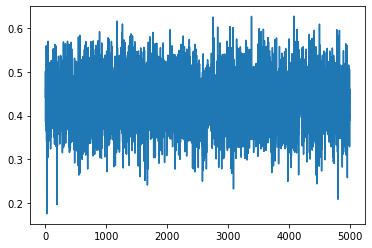

In [7]:
plt.plot(np.hstack(q6s))

### Adding a clustering condition

We will now modify the above function to also find clusters which satisfy particular $q_6$ value. But first, for a single file.

In [8]:
sys = pc.System()
sys.read_inputfile(files[0])
sys.find_neighbors(method="cutoff", cutoff=0)
sys.calculate_q(6)

Now a clustering algorithm can be applied on top using the `cluster_atoms` method. `cluster_atoms` uses a `condition as argument` which should give a True/False value for each atom. Lets define a condition.

In [9]:
def condition(atom):
    return atom.get_q(6) > 0.5

The above function returns `True` for any atom which has a $q_6$ value greater than 0.5 and `False` otherwise. Now we can call the `cluster_atoms` method.

In [10]:
sys.cluster_atoms(condition)

16

The method returns 16, which here is the size of the largest cluster of atoms which have $q_6$ value of 0.5 or higher. If information about all clusters are required, that can also be accessed.

In [11]:
atoms = sys.atoms

`atom.cluster` gives the number of the cluster that each atom belongs to. If the value is -1, the atom does not belong to any cluster, that is, the clustering condition was not met.

In [12]:
clusters = [atom.cluster for atom in atoms if atom.cluster != -1]

Now we can see how many unique clusters are there, and what their sizes are.

In [13]:
unique_clusters, counts = np.unique(clusters, return_counts=True)

`counts` contain all the necessary information. `len(counts)` will give the number of unique clusters.

Text(0.5, 0, 'Cluster ID')

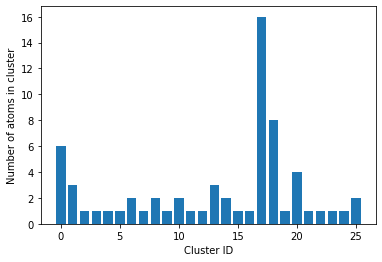

In [14]:
plt.bar(range(len(counts)), counts)
plt.ylabel("Number of atoms in cluster")
plt.xlabel("Cluster ID")

Now we can finally put all of these together into a single function and run it over our individual time slices.

In [15]:
def calculate_q6_cluster(file, cutoff_q6 = 0.5, format="lammps-dump"):
    sys = pc.System()
    sys.read_inputfile(file, format=format)
    sys.find_neighbors(method="cutoff", cutoff=0)
    sys.calculate_q(6)
    def _condition(atom):
        return atom.get_q(6) > cutoff_q6
    sys.cluster_atoms(condition)
    atoms = sys.atoms
    clusters = [atom.cluster for atom in atoms if atom.cluster != -1]
    unique_clusters, counts = np.unique(clusters, return_counts=True)
    return counts

In [16]:
q6clusters = [calculate_q6_cluster(file) for file in files]

We can plot the number of clusters for each slice

Text(0, 0.5, 'number of unique clusters')

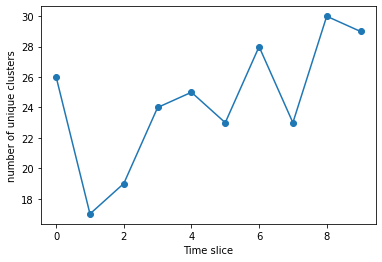

In [17]:
plt.plot(range(len(q6clusters)), [len(x) for x in q6clusters], 'o-')
plt.xlabel("Time slice")
plt.ylabel("number of unique clusters")

We can also plot the biggest cluster size

Text(0, 0.5, 'Largest cluster size')

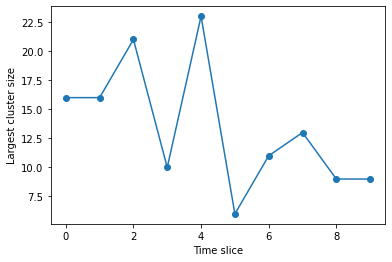

In [18]:
plt.plot(range(len(q6clusters)), [max(x) for x in q6clusters], 'o-')
plt.xlabel("Time slice")
plt.ylabel("Largest cluster size")

The final thing to do is to remove the split files after use.

In [19]:
for file in files:
    os.remove(file)

### Using [ASE](https://wiki.fysik.dtu.dk/ase/)

The above example can also done using ASE. The ASE read method needs to be imported.

In [20]:
from ase.io import read

In [21]:
traj = read("traj.light", format="lammps-dump-text", index=":")

In the above function, `index=":"` tells ase to read the complete trajectory. The individual slices can now be accessed by indexing.

In [22]:
traj[0]

Atoms(symbols='H500', pbc=True, cell=[18.21922, 18.22509, 18.36899], momenta=...)

We can use the same functions as above, but by specifying a different file format.

In [23]:
q6clusters_ase = [calculate_q6_cluster(x, format="ase") for x in traj]

We will plot and compare with the results from before,

Text(0, 0.5, 'Largest cluster size')

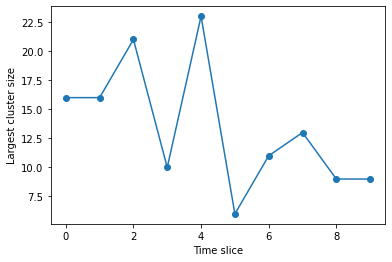

In [24]:
plt.plot(range(len(q6clusters_ase)), [max(x) for x in q6clusters_ase], 'o-')
plt.xlabel("Time slice")
plt.ylabel("Largest cluster size")

As expected, the results are identical for both calculations!